In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from matplotlib import pyplot as plt
from src.utils import get_mnist_data, get_device
from src.models import ConvNN
from src.training_and_evaluation import train_model, predict_model, standard_loss
from src.attacks import gradient_attack, attack
import os
if not os.path.isdir("models"):
    os.mkdir("models")
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Project 2, part 1: Creating adversarial examples 
In this notebook we train a basic convolutional neural network on MNIST and craft adversarial examples via gradient descent.

## Your task
Complete the missing code in the respective files, i.e. `training_and_evaluation.py`, `attacks.py`. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Specifically, for this part you will have to implement the following functions / classes:  
**`training_and_evaluation.py`**:
* `training_step` 
* `prediction` 
* `standard_loss`

**`attacks.py`**:
* `gradient_attack` 
* `attack`

## General remarks
Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

Note that plagiarising even a single project task will make you ineligible for the bonus this semester.

In [2]:
mnist_trainset = get_mnist_data(train=True)
mnist_testset = get_mnist_data(train=False)
device = get_device()

model = ConvNN()
model.to(device)

epochs = 1
batch_size = 128
test_batch_size = 1000  # feel free to change this
lr = 1e-3

opt = Adam(model.parameters(), lr=lr)

Implement the function `training_step` in the file `training_and_evaluation.py`.

In [3]:
losses, accuracies = train_model(model, mnist_trainset, batch_size, device, loss_function=standard_loss, optimizer=opt)

INFO:root:Epoch 0 Iteration 0: Loss=2.494985342025757 Accuracy=0.0078125
INFO:root:Epoch 0 Iteration 100: Loss=0.3630991578102112 Accuracy=0.9296875
INFO:root:Epoch 0 Iteration 200: Loss=0.2444041669368744 Accuracy=0.921875
INFO:root:Epoch 0 Iteration 300: Loss=0.22088313102722168 Accuracy=0.9375
INFO:root:Epoch 0 Iteration 400: Loss=0.12290540337562561 Accuracy=0.96875


In [4]:
torch.save(model.state_dict(), "models/standard_training.checkpoint")

In [5]:
model.load_state_dict(torch.load("models/standard_training.checkpoint", 
                                 map_location="cpu"))

<All keys matched successfully>

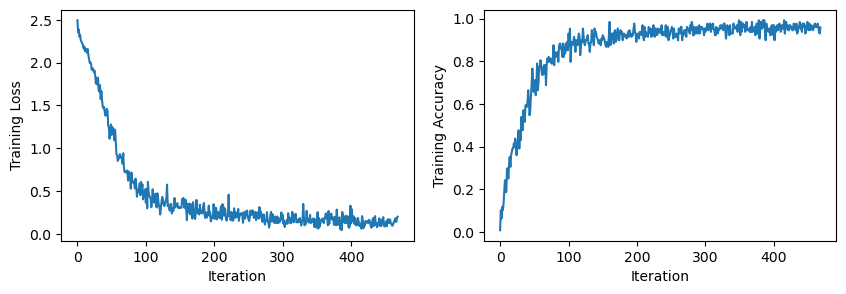

In [6]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

Implement the `prediction` function in the file `training_and_evaluation.py`.
Note that in order to get points for the task you have to extend the implementation of the `prediction` function during the course of this notebook.

In [7]:
clean_accuracy = predict_model(model, mnist_testset, test_batch_size, device=device,
                               attack_function=None)

In [8]:
clean_accuracy

0.9585000276565552

### Creating adversarial examples
#### $L_2$-bounded attacks
Fist, craft adversarial perturbations that have a $L_2$ norm of $ \| \tilde{\mathbf{x}} - \mathbf{x} \|_2 = \epsilon$ with $\epsilon=5$.

#### $L_\infty$-bounded attacks
Afterwards, craft adversarial perturbations with $L_\infty$ norm of $ \| \tilde{\mathbf{x}} - \mathbf{x} \|_\infty = \epsilon$ with $\epsilon=0.3$.

For this you need to implement `predict_model` in the file `training_and_evaluation.py` and `gradient_attack` in `attacks.py`. See the docstring comments there.

In [9]:
attack_args_l2 = {"epsilon": 5, "norm": "2"}
attack_args_linf = {"epsilon": 0.3, "norm": "inf"}

### Qualitative evaluation

First, craft adversarial examples for 10 randomly selected test samples and inspect them by plotting them.

For this you have to implement the function `attack` in the file `attacks.py`. 

$L_2$ attack:

In [10]:
test_loader = DataLoader(mnist_testset, batch_size = 10, shuffle=False)
x,y = next(iter(test_loader))

x_pert_l2, y_pert_l2 = attack(x,y,model, attack_args_l2)

$L_\infty$ attack:

In [11]:
x_pert_linf, y_pert_linf = attack(x,y,model, attack_args_linf)

Visualize the adversarial examples and the model's prediction on them:

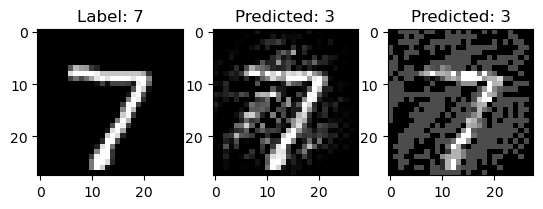

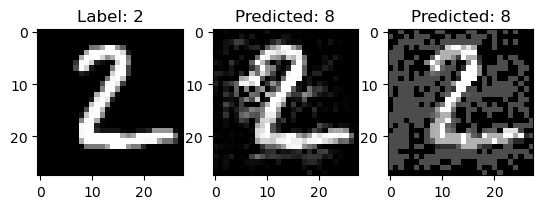

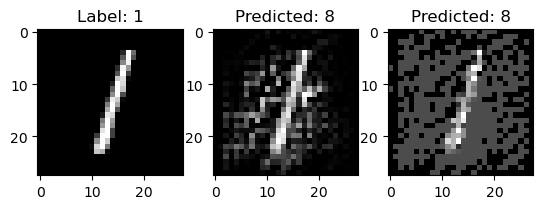

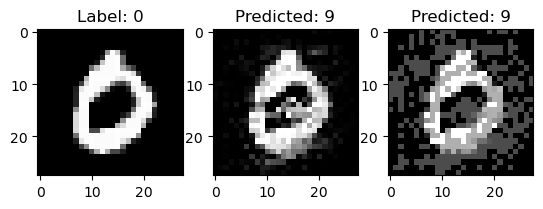

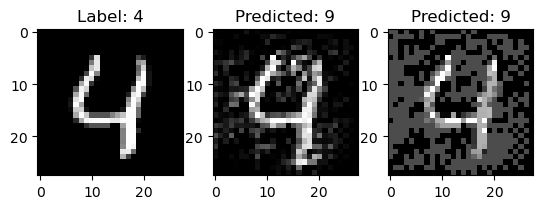

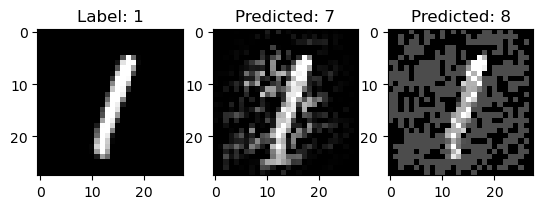

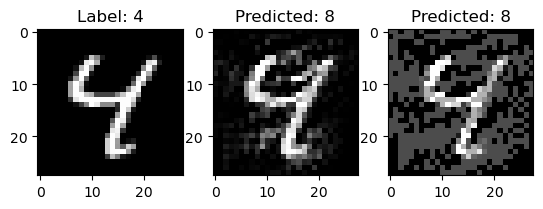

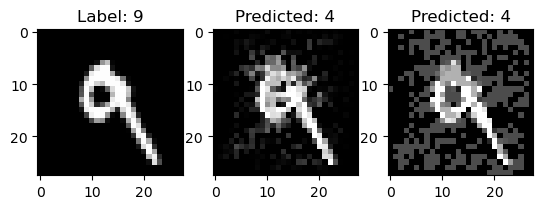

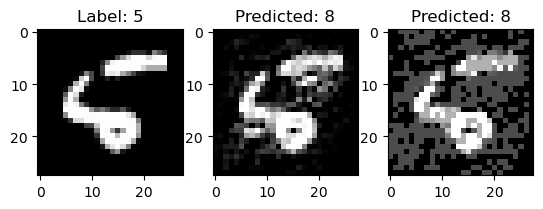

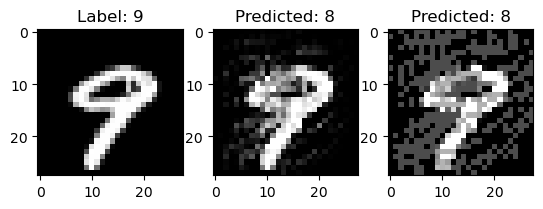

In [12]:
for ix in range(len(x)):
    plt.subplot(131)
    plt.imshow(x[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Label: {y[ix]}")
    plt.subplot(132)
    plt.imshow(x_pert_l2[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Predicted: {y_pert_l2[ix]}")
    
    plt.subplot(133)
    plt.imshow(x_pert_linf[ix,0].detach().cpu(), cmap="gray")
    plt.title(f"Predicted: {y_pert_linf[ix]}")
    plt.show()

### Quantitative evaluation
Perturb each test sample and compare the clean and perturbed accuracies.

$L_2$ perturbations:

In [13]:
perturbed_accuracy_l2 = predict_model(model, mnist_testset, 
                                      batch_size=test_batch_size, 
                                      device=device, 
                                      attack_function=gradient_attack, 
                                      attack_args=attack_args_l2)

$L_\infty$ perturbations:

In [14]:
perturbed_accuracy_linf = predict_model(model, mnist_testset, 
                                        batch_size=test_batch_size, 
                                        device=device, 
                                        attack_function=gradient_attack, 
                                        attack_args=attack_args_linf)

Your values for `clean_accuracy` and `perturbed_accuracy` should roughly match the ones below, even though they will of course not be identical.

In [15]:
clean_accuracy

0.9585000276565552

In [16]:
perturbed_accuracy_l2

0.03779999911785126

In [17]:
perturbed_accuracy_linf

0.006800000090152025

#### In the remaining parts of this project we will be focusing on **$L_2$-based attacks only**.